# AI-Enhanced Early Warning System for Multi-Hazard Scenarios: India-wide with Major Cities

In [1]:

!pip install requests pandas numpy plotly folium scikit-learn matplotlib seaborn

In [2]:

import requests
import pandas as pd
import numpy as np
import plotly.express as px
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
# Step 1: Major Indian Cities
cities_india = {
    "Delhi": (28.6139, 77.2090),
    "Lucknow": (26.8467, 80.9462),
    "Chandigarh": (30.7333, 76.7794),
    "Shimla": (31.1048, 77.1734),
    "Srinagar": (34.0837, 74.7973),
    "Leh": (34.1526, 77.5771),
    "Jaipur": (26.9124, 75.7873),
    "Dehradun": (30.3165, 78.0322),
    "Mumbai": (19.0760, 72.8777),
    "Pune": (18.5204, 73.8567),
    "Gandhinagar": (23.2156, 72.6369),
    "Panaji": (15.4909, 73.8278),
    "Chennai": (13.0827, 80.2707),
    "Bengaluru": (12.9716, 77.5946),
    "Hyderabad": (17.3850, 78.4867),
    "Thiruvananthapuram": (8.5241, 76.9366),
    "Kolkata": (22.5726, 88.3639),
    "Patna": (25.5941, 85.1376),
    "Ranchi": (23.3441, 85.3096),
    "Bhubaneswar": (20.2961, 85.8245),
    "Guwahati": (26.1445, 91.7362),
    "Imphal": (24.8170, 93.9368),
    "Shillong": (25.5788, 91.8933),
    "Aizawl": (23.7271, 92.7176),
    "Kohima": (25.6751, 94.1086),
    "Agartala": (23.8315, 91.2868),
    "Itanagar": (27.0844, 93.6053),
    "Gangtok": (27.3389, 88.6065),
    "Bhopal": (23.2599, 77.4126),
    "Raipur": (21.2514, 81.6296),
}

# Step 2: Fetch Weather Data
data_list = []

for city, (lat, lon) in cities_india.items():
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,precipitation,wind_speed_10m"
    response = requests.get(url).json()

    try:
        temp = np.mean(response['hourly']['temperature_2m'])
        rain = np.mean(response['hourly']['precipitation'])
        wind = np.mean(response['hourly']['wind_speed_10m'])
    except:
        temp, rain, wind = None, None, None

    data_list.append({
        "city": city,
        "latitude": lat,
        "longitude": lon,
        "temperature": temp,
        "rainfall": rain,
        "wind_speed": wind
    })

df = pd.DataFrame(data_list)

# Step 3: Save and Reload Dataset
path = "/content/disaster_dataset.csv"
df.to_csv(path, index=False)
print(f"Dataset saved at {path}")

Dataset saved at /content/disaster_dataset.csv


In [4]:
# Reload
data = pd.read_csv(path)

print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         30 non-null     object 
 1   latitude     30 non-null     float64
 2   longitude    30 non-null     float64
 3   temperature  30 non-null     float64
 4   rainfall     30 non-null     float64
 5   wind_speed   30 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.5+ KB
None


In [5]:
display(data.head())

,city,latitude,longitude,temperature,rainfall,wind_speed
0,Delhi,28.6139,77.2090,29.207738,0.135119,5.817262
1,Lucknow,26.8467,80.9462,29.370833,0.317857,4.431548
2,Chandigarh,30.7333,76.7794,27.425000,0.182738,7.301190
3,Shimla,31.1048,77.1734,18.589286,0.269643,4.725595
4,Srinagar,34.0837,74.7973,19.954167,0.006548,4.573214


In [6]:
print("\nNumber of Unique Values per Column:")
print(data.nunique())


Number of Unique Values per Column:
city           30
latitude       30
longitude      30
temperature    30
rainfall       29
wind_speed     30
dtype: int64


In [7]:
print("\nDataset Description:")
print(data.describe())


Dataset Description:
        latitude  longitude  temperature   rainfall  wind_speed
count  30.000000  30.000000    30.000000  30.000000   30.000000
mean   23.718190  82.211950    25.015000   0.261329    5.691786
std     6.118056   7.243863     4.144927   0.230080    3.296193
min     8.524100  72.636900    13.620238   0.006548    3.214286
25%    20.534925  76.995800    22.442411   0.068006    3.964137
50%    24.324250  79.378700    26.309821   0.210417    4.649405
75%    27.041400  88.545850    28.083036   0.433333    6.372321
max    34.152600  94.108600    30.333333   0.834524   21.084524


In [8]:

print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
city           0
latitude       0
longitude      0
temperature    0
rainfall       0
wind_speed     0
dtype: int64


In [9]:
# Number of rows and columns
data.shape

(30, 6)

In [10]:
# Fill missing values with mean for numeric columns only
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [11]:
# Step 5: Synthetic Hazard Labels
np.random.seed(42)
data["flood"] = np.random.randint(0, 2, size=len(data))
data["drought"] = np.random.randint(0, 2, size=len(data))
data["cyclone"] = np.random.randint(0, 2, size=len(data))

In [12]:
# Step 6: Train/Test Split
X = data[["temperature", "rainfall", "wind_speed"]]
y = data[["flood", "drought", "cyclone"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensemble Models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb)
], voting='soft')

multi_target_model = MultiOutputClassifier(ensemble)
multi_target_model.fit(X_train, y_train)

y_pred = multi_target_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Flood", "Drought", "Cyclone"]))


Classification Report:
              precision    recall  f1-score   support

       Flood       1.00      0.75      0.86         4
     Drought       0.33      0.50      0.40         2
     Cyclone       0.75      0.60      0.67         5

   micro avg       0.70      0.64      0.67        11
   macro avg       0.69      0.62      0.64        11
weighted avg       0.77      0.64      0.69        11
 samples avg       0.58      0.58      0.56        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Step 7: Hazard Probabilities per City
probs = []
for _, row in data.iterrows():
    x = row[['temperature', 'rainfall', 'wind_speed']].values.reshape(1,-1)
    prob = multi_target_model.predict_proba(x)
    # Assuming the order of classes is consistent: Flood, Drought, Cyclone
    prob = [p[0][1] for p in prob]  # extract hazard probs
    probs.append(prob)

data['Flood_prob'], data['Drought_prob'], data['Cyclone_prob'] = np.array(probs).T

city_probs = data.groupby('city')[['latitude', 'longitude', 'Flood_prob','Drought_prob','Cyclone_prob']].mean().reset_index()
print("\nAverage Hazard Probabilities by City:")
display(city_probs)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/u


Average Hazard Probabilities by City:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


,city,latitude,longitude,Flood_prob,Drought_prob,Cyclone_prob
0,Agartala,23.8315,91.2868,0.964155,0.863475,0.050710
1,Aizawl,23.7271,92.7176,0.899593,0.860473,0.839701
2,Bengaluru,12.9716,77.5946,0.041079,0.930420,0.949424
3,Bhopal,23.2599,77.4126,0.805354,0.138094,0.969292
4,Bhubaneswar,20.2961,85.8245,0.127857,0.885266,0.873973
5,Chandigarh,30.7333,76.7794,0.096932,0.911583,0.120369
6,Chennai,13.0827,80.2707,0.055196,0.849690,0.145799
7,Dehradun,30.3165,78.0322,0.139878,0.051220,0.090651
8,Delhi,28.6139,77.2090,0.136677,0.172315,0.201346
9,Gandhinagar,23.2156,72.6369,0.020288,0.185751,0.894292


In [14]:
# Step 8: Interactive Plotly Dashboard
fig = px.bar(
    city_probs.melt(id_vars='city', value_vars=['Flood_prob', 'Drought_prob', 'Cyclone_prob'], var_name='Hazard', value_name='Probability'),
    x='city', y='Probability', color='Hazard', barmode='group',
    title="Interactive Hazard Probabilities Across India"
)
fig.show()

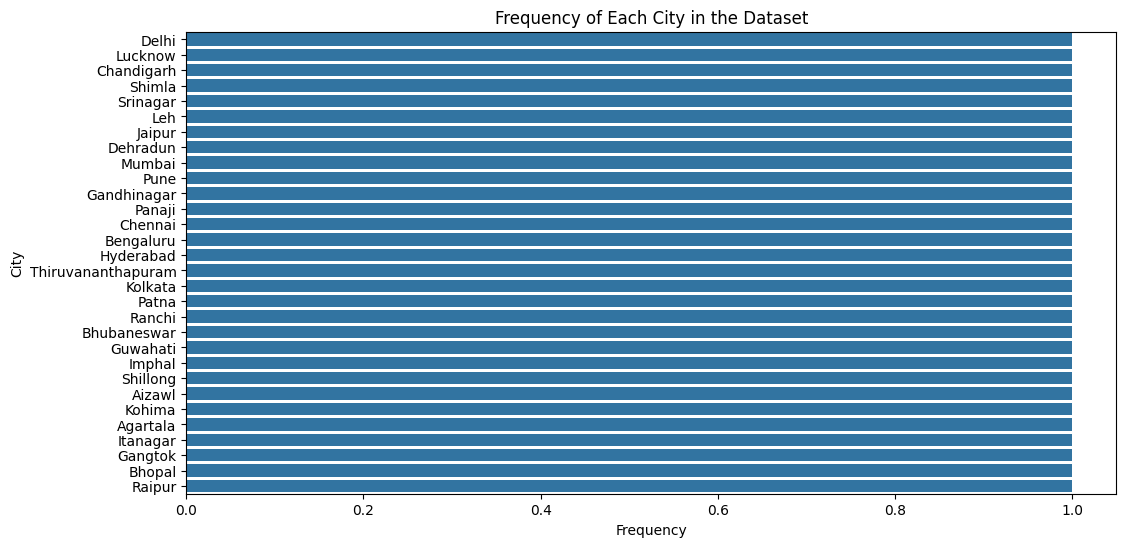

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='city', order=data['city'].value_counts().index)
plt.title('Frequency of Each City in the Dataset')
plt.xlabel('Frequency')
plt.ylabel('City')
plt.show()

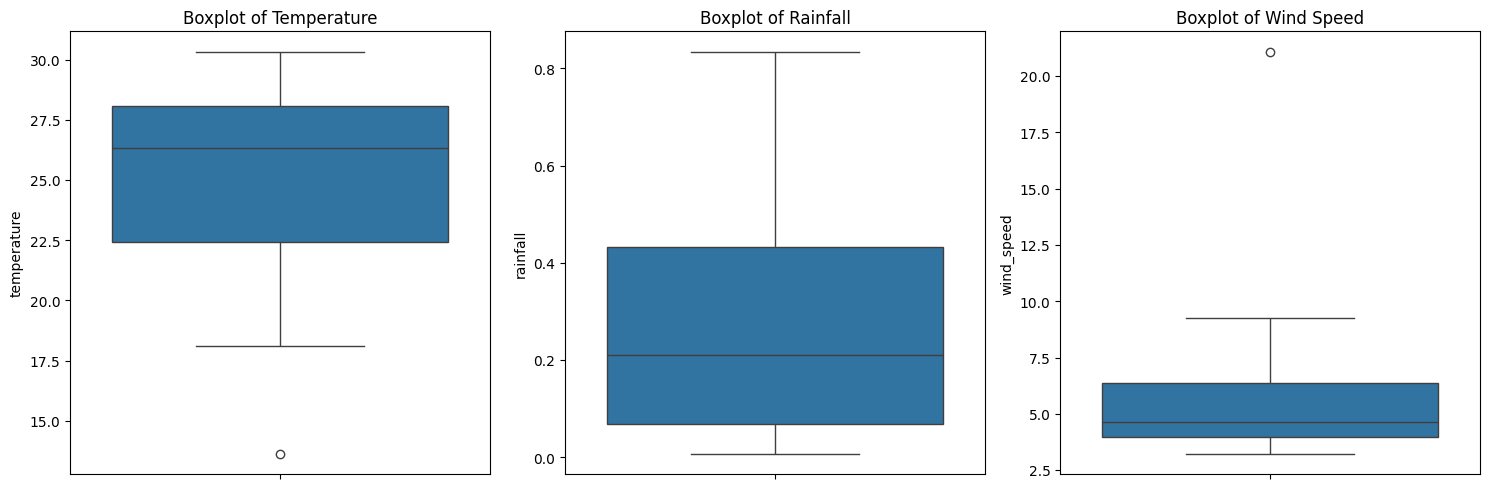

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=data, y='temperature')
plt.title('Boxplot of Temperature')

plt.subplot(1, 3, 2)
sns.boxplot(data=data, y='rainfall')
plt.title('Boxplot of Rainfall')

plt.subplot(1, 3, 3)
sns.boxplot(data=data, y='wind_speed')
plt.title('Boxplot of Wind Speed')

plt.tight_layout()
plt.show()

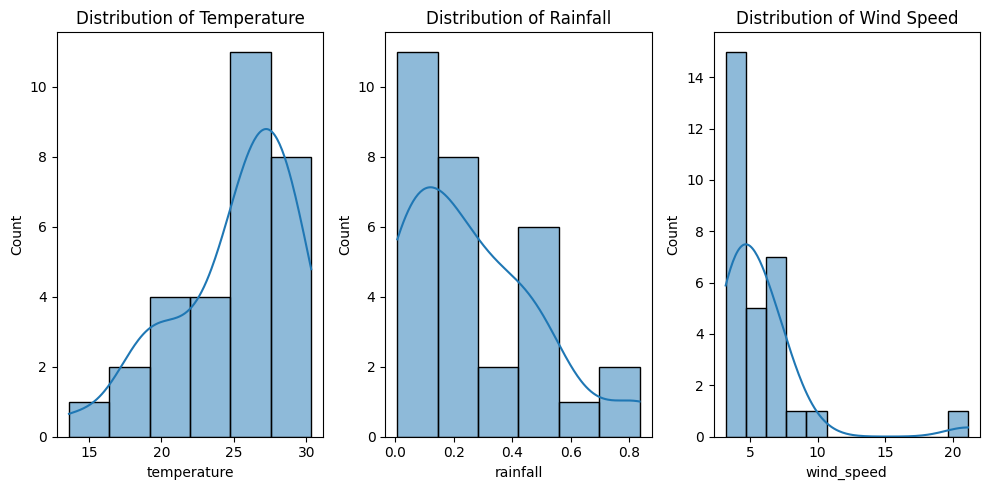

In [17]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=data, x='temperature', kde=True)
plt.title('Distribution of Temperature')

plt.subplot(1, 3, 2)
sns.histplot(data=data, x='rainfall', kde=True)
plt.title('Distribution of Rainfall')

plt.subplot(1, 3, 3)
sns.histplot(data=data, x='wind_speed', kde=True)
plt.title('Distribution of Wind Speed')

plt.tight_layout()
plt.show()

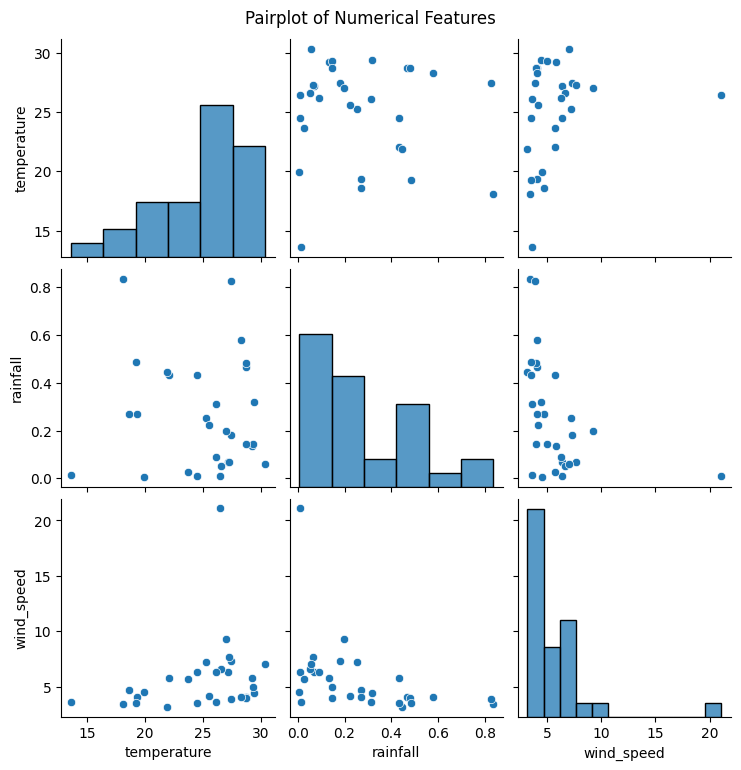

In [18]:
sns.pairplot(data[['temperature', 'rainfall', 'wind_speed']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

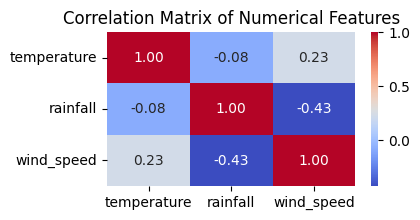

In [19]:
numerical_data = data[['temperature', 'rainfall', 'wind_speed']]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(4, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [20]:
# One-hot encode the 'city' column
city_encoded = pd.get_dummies(data['city'], prefix='city')

# Concatenate the encoded city columns with the numerical features
X_transformed = pd.concat([data[['temperature', 'rainfall', 'wind_speed']], city_encoded], axis=1)

# Display the first few rows of the transformed feature set
display(X_transformed.head())

,temperature,rainfall,wind_speed,city_Agartala,city_Aizawl,city_Bengaluru,city_Bhopal,city_Bhubaneswar,city_Chandigarh,city_Chennai,...,city_Mumbai,city_Panaji,city_Patna,city_Pune,city_Raipur,city_Ranchi,city_Shillong,city_Shimla,city_Srinagar,city_Thiruvananthapuram
0,29.207738,0.135119,5.817262,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,29.370833,0.317857,4.431548,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,27.425000,0.182738,7.301190,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,18.589286,0.269643,4.725595,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,19.954167,0.006548,4.573214,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [21]:
#Split the dataset into features (X) and target labels (y), and then further split these into training and testing sets.
from sklearn.model_selection import train_test_split

X = data[["temperature", "rainfall", "wind_speed"]]
y = data[["flood", "drought", "cyclone"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training features shape: (24, 3)
Testing features shape: (6, 3)
Training labels shape: (24, 3)
Testing labels shape: (6, 3)


In [22]:
#Train a multi-output classification model using an ensemble of RandomForest and GradientBoosting classifiers on the training data.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.multioutput import MultiOutputClassifier

rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

ensemble = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb)
], voting='soft')

multi_target_model = MultiOutputClassifier(ensemble)
multi_target_model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


In [23]:
#Evaluate the trained model on the test data and print the classification report.
from sklearn.metrics import classification_report

y_pred = multi_target_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Flood", "Drought", "Cyclone"]))


Classification Report:
              precision    recall  f1-score   support

       Flood       1.00      0.75      0.86         4
     Drought       0.33      0.50      0.40         2
     Cyclone       0.75      0.60      0.67         5

   micro avg       0.70      0.64      0.67        11
   macro avg       0.69      0.62      0.64        11
weighted avg       0.77      0.64      0.69        11
 samples avg       0.58      0.58      0.56        11



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [24]:
#Calculate Hazard Probabilities per City: Use the trained model to predict the probability of each hazard for each city in the dataset and create a DataFrame with these probabilities.
probs = []
for _, row in data.iterrows():
    x = row[['temperature', 'rainfall', 'wind_speed']].values.reshape(1,-1)
    prob = multi_target_model.predict_proba(x)
    # Assuming the order of classes is consistent: Flood, Drought, Cyclone
    prob = [p[0][1] for p in prob]  # extract hazard probs
    probs.append(prob)

data['Flood_prob'], data['Drought_prob'], data['Cyclone_prob'] = np.array(probs).T

city_probs = data.groupby('city')[['latitude', 'longitude', 'Flood_prob','Drought_prob','Cyclone_prob']].mean().reset_index()
print("\nAverage Hazard Probabilities by City:")
display(city_probs)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: Use


Average Hazard Probabilities by City:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739:

,city,latitude,longitude,Flood_prob,Drought_prob,Cyclone_prob
0,Agartala,23.8315,91.2868,0.964155,0.863475,0.050710
1,Aizawl,23.7271,92.7176,0.899593,0.860473,0.839701
2,Bengaluru,12.9716,77.5946,0.041079,0.930420,0.949424
3,Bhopal,23.2599,77.4126,0.805354,0.138094,0.969292
4,Bhubaneswar,20.2961,85.8245,0.127857,0.885266,0.873973
5,Chandigarh,30.7333,76.7794,0.096932,0.911583,0.120369
6,Chennai,13.0827,80.2707,0.055196,0.849690,0.145799
7,Dehradun,30.3165,78.0322,0.139878,0.051220,0.090651
8,Delhi,28.6139,77.2090,0.136677,0.172315,0.201346
9,Gandhinagar,23.2156,72.6369,0.020288,0.185751,0.894292


In [25]:
import folium
from folium import plugins

# Base map
india_map = folium.Map(location=[22.9734, 78.6569], zoom_start=5)

# Feature groups for disasters
disaster_layers = {
    "Flood": folium.FeatureGroup(name="Flood Risk"),
    "Drought": folium.FeatureGroup(name="Drought Risk"),
    "Cyclone": folium.FeatureGroup(name="Cyclone Risk"),
    "All": folium.FeatureGroup(name="All Risks")
}

# Add markers to each layer
for _, row in city_probs.iterrows():
    # Individual risks
    risks = {
        "Flood": row["Flood_prob"],
        "Drought": row["Drought_prob"],
        "Cyclone": row["Cyclone_prob"]
    }

    for disaster, risk_value in risks.items():
        color = "green" if risk_value <= 0.3 else "orange" if risk_value <= 0.6 else "red"
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=8,
            popup=f"{row['city']} - {disaster} Risk: {risk_value:.2f}",
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7
        ).add_to(disaster_layers[disaster])

    # Combined "All Risks" marker
    total_risk = sum(risks.values()) / 3
    all_color = "green" if total_risk <= 0.3 else "orange" if total_risk <= 0.6 else "red"
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=10,
        popup=f"{row['city']} - Total Risk: {total_risk:.2f}",
        color=all_color,
        fill=True,
        fill_color=all_color,
        fill_opacity=0.7
    ).add_to(disaster_layers["All"])

    # Extreme risk blinking alerts
    if total_risk > 0.8:
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            icon=folium.DivIcon(html=f"""
            <div style="color:red; font-weight:bold; animation: blinker 1s linear infinite;">
            ⚠️ {row['city']} Extreme Risk ({total_risk:.2f})
            </div>
            """)
        ).add_to(india_map)

# Add layers to map
for layer in disaster_layers.values():
    layer.add_to(india_map)

# Heatmap layer for overall risk
heat_data = [[row["latitude"], row["longitude"],
              (row["Flood_prob"] + row["Drought_prob"] + row["Cyclone_prob"])/3]
             for _, row in city_probs.iterrows()]
plugins.HeatMap(heat_data, radius=25, blur=15, max_zoom=10).add_to(india_map)

# Layer control
folium.LayerControl(collapsed=False).add_to(india_map)

# Legend & CSS for blinking
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 160px;
            border:2px solid grey; z-index:9999; font-size:14px; background-color:white; padding: 10px;">
<b> Risk Level </b><br>
<i style="background:green; width:15px; height:15px; float:left; margin-right:8px;"></i> Low (≤ 0.3)<br>
<i style="background:orange; width:15px; height:15px; float:left; margin-right:8px;"></i> Medium (0.3–0.6)<br>
<i style="background:red; width:15px; height:15px; float:left; margin-right:8px;"></i> High (> 0.6)<br>
</div>
<style>
@keyframes blinker { 50% { opacity: 0; } }
</style>
'''
india_map.get_root().html.add_child(folium.Element(legend_html))

india_map